# Scalar Quantization

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Comparison of different scalar quantization methods
* Uniform scalar quantization of audio files with midrise and midtread characteristic
* Non-uniform scalar quantization with $\mu$-law characteristic
* Optimal quantization with Lloyd-Max codebook
* Adaptive quantization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from pylab import rcParams
rcParams['axes.xmargin'] = 0

Load and display wave file

In [2]:
wave_filename = '../audio/33711__acclivity__excessiveexposure.wav'
#wave_filename = '../audio/E-Core - Pingouin-Banquise_45s.wav'
#wave_filename = '../audio/KIMIKO ISHIZAKA - Goldberg Variations BWV 988 - 01 - Aria_45s.wav'
x, sampling_rate = librosa.load(wave_filename)

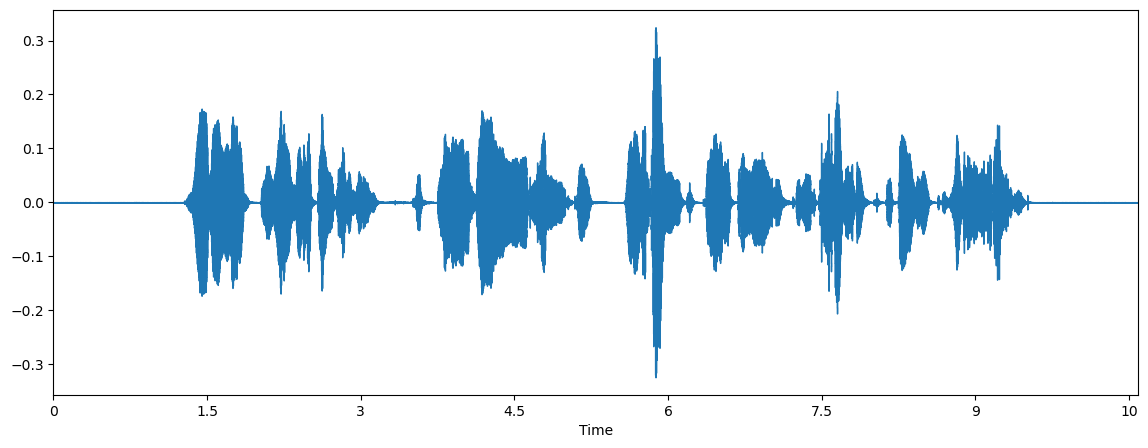

In [3]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sampling_rate)

Play wave file

In [4]:
ipd.Audio(wave_filename) # load a local WAV file

## Uniform Quantization with Midrise Quantizer

In [5]:
# Sample to 4 bit ... 16 quantization levels
w = 4

# fix x_max based on the current signal, leave some room
x_max = np.max([np.max(x), -np.min(x)])
Delta_x = x_max / (2**(w-1))


xh_uniform_midrise = np.sign(x)*Delta_x*(np.floor(np.abs(x)/Delta_x)+0.5) 

# playback quantized audio
ipd.Audio(xh_uniform_midrise, rate=sampling_rate)

(-0.38965744972229005, 0.38965744972229005)

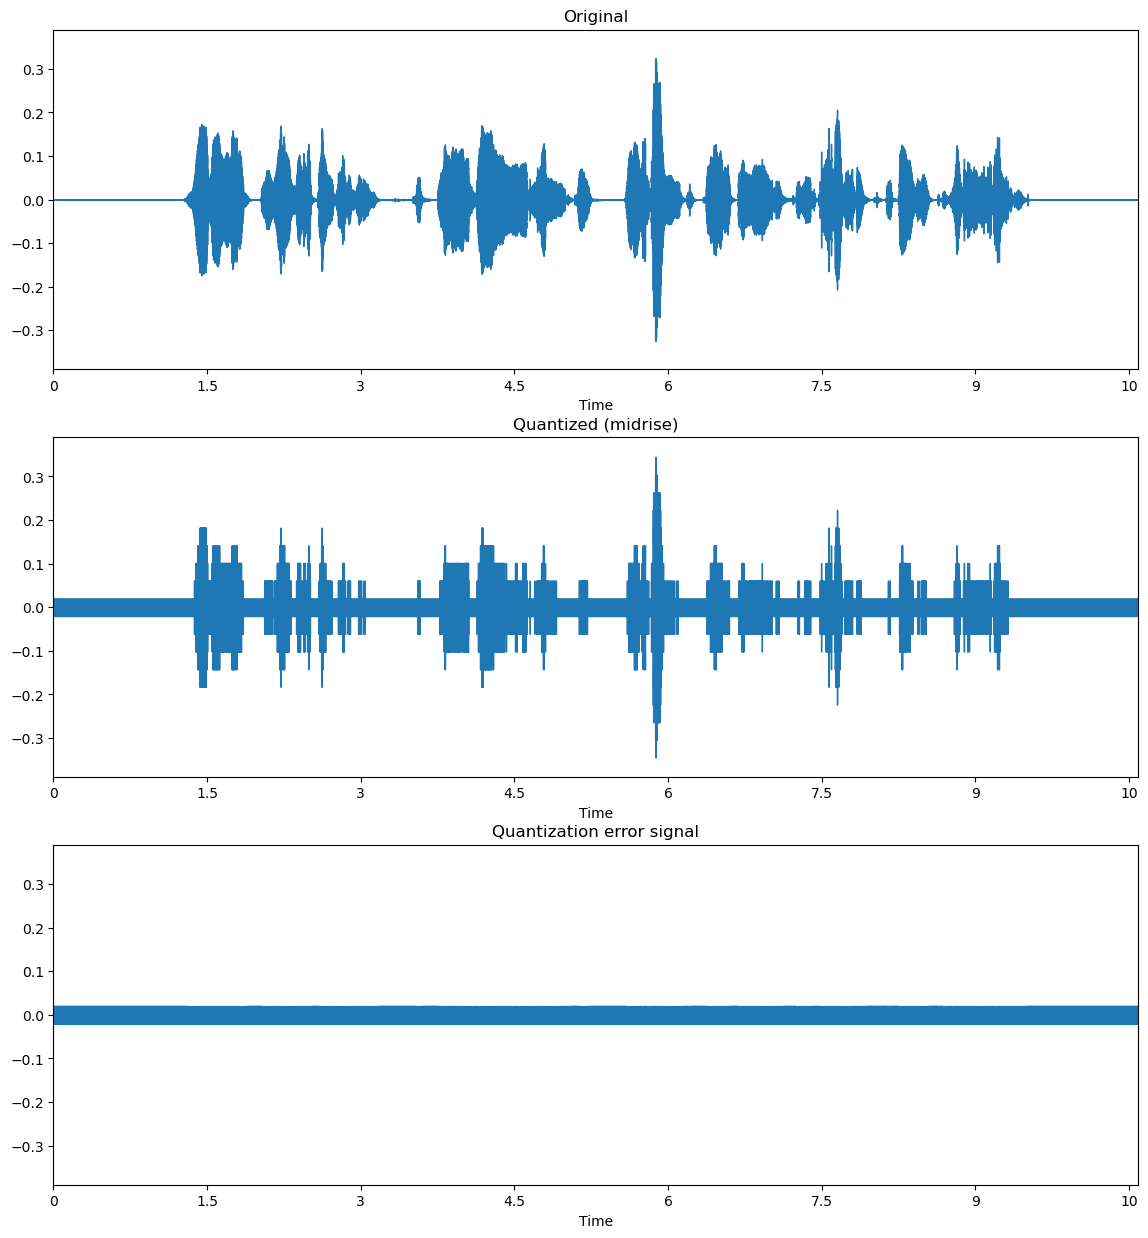

In [6]:
plt.figure(figsize=(14, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveshow(xh_uniform_midrise, sr=sampling_rate)
plt.title('Quantized (midrise)')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveshow(x-xh_uniform_midrise, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

## Uniform Quantization with Midtread Quantizer

In [7]:
# fix x_max based on the current signal, leave some room
x_max = np.max(x)
Delta_x = x_max / (2**(w-1))


xh_uniform_midtread = np.sign(x)*Delta_x*np.floor(np.abs(x)/Delta_x+0.5)

# saturate
xh_max = (2**(w-1)*Delta_x - Delta_x)
xh_min = -(xh_max + Delta_x)
xh_uniform_midtread[xh_uniform_midtread >= xh_max] = xh_max
xh_uniform_midtread[xh_uniform_midtread <= xh_min] = xh_min


# playback quantized audio
ipd.Audio(xh_uniform_midtread, rate=sampling_rate)

(-0.3257324695587158, 0.3257324695587158)

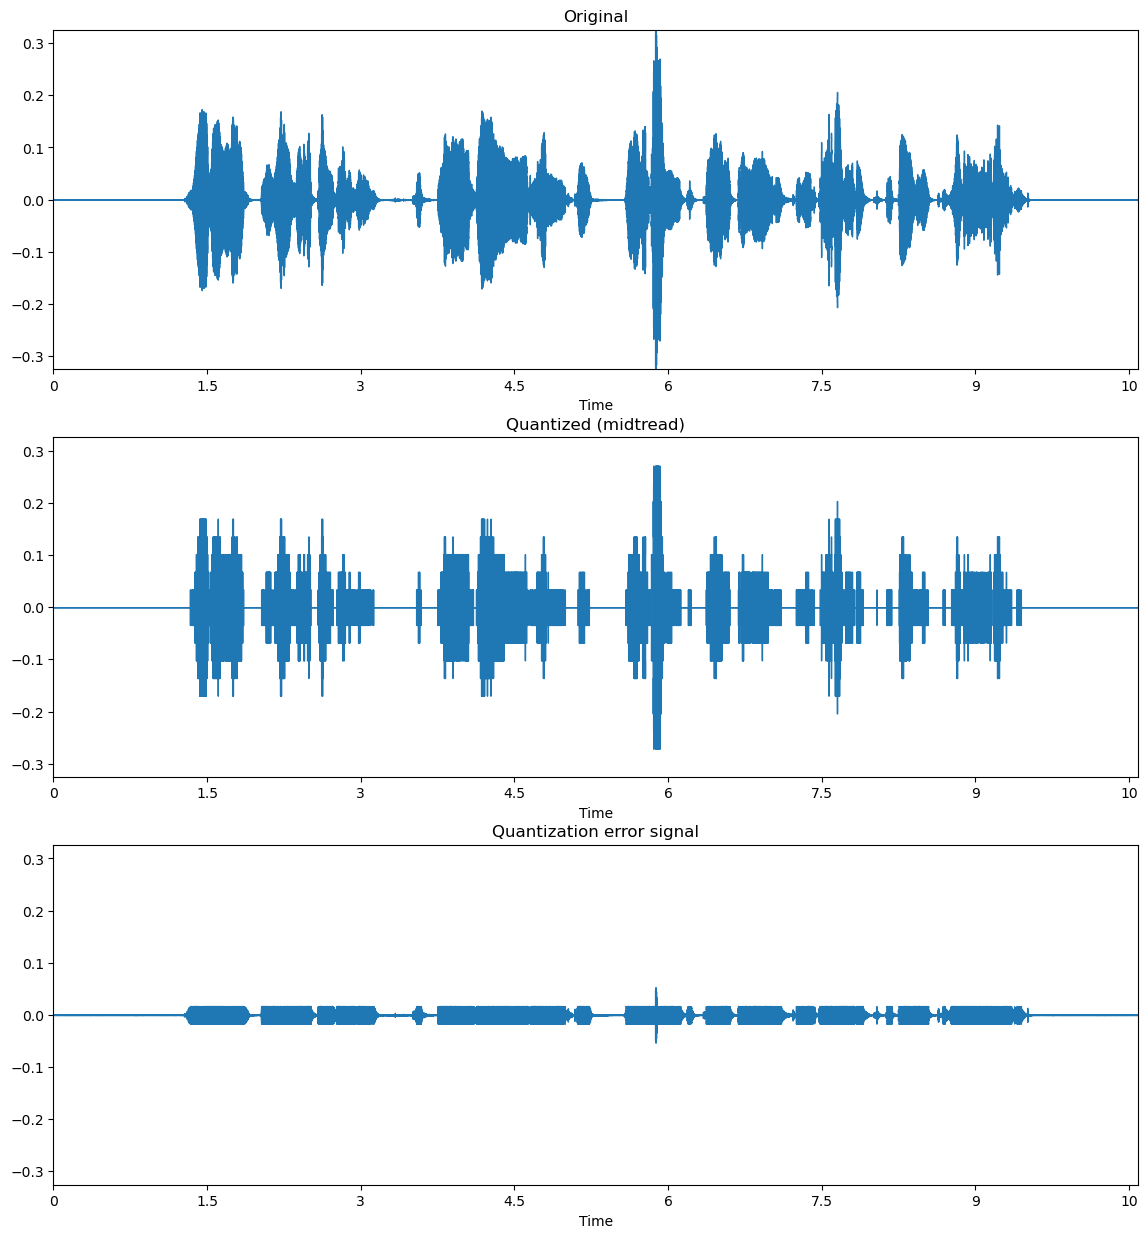

In [8]:
plt.figure(figsize=(14, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveshow(xh_uniform_midtread, sr=sampling_rate)
plt.title('Quantized (midtread)')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveshow(x-xh_uniform_midtread, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

## Non-Uniform Quantization

Compress and expand the signal using $\mu$-law companders prior to uniform quantization with
$$
g_{\mu}(x) = \mathrm{sign}(x)\frac{\ln(1+\mu|x|)}{\ln(1+\mu)}
$$
and the inverse
$$
g^{-1}_{\mu}(y) = \mathrm{sign}(y)\frac{1}{\mu}\left((1+\mu)^{|y|}-1\right)
$$

In [9]:
def ALaw(x):
    A = 87.56
    y = np.zeros_like(x)
    idx_case1 = abs(x) <= 1/A
    idx_case2 = [not k for k in idx_case1]
    y[idx_case1] = A*x[idx_case1]/(1+np.log(A))
    y[idx_case2] = np.sign(x[idx_case2])*(1+np.log(A*np.abs(x[idx_case2])))/(1+np.log(A))
    return y

def uLaw(x):
    mu = 255
    y = np.array([np.sign(t)*np.log(1+mu*np.abs(t))/np.log(1+mu) for t in x])
    return y

def uLaw_inv(y):
    mu = 255
    x = np.array([np.sign(t)/mu*((1+mu)**(np.sign(t)*t)-1) for t in y])
    return x

In [10]:
# apply mu-law compression. First normalize signal to the range [-1,1] and then un-normalize
x_ulaw = uLaw(np.array(x)/x_max)

# quantize (attention, now input signal is in the range [-1,+1], i.e., x_max = 1)
Delta_x = 1 / (2**(w-1))
quantized = np.sign(x_ulaw)*Delta_x*(np.floor(np.abs(x_ulaw)/Delta_x)+0.5) 

# apply inverse mu-law compression
xh_nonuniform = uLaw_inv(np.array(quantized))*x_max

# playback quantized audio
ipd.Audio(xh_nonuniform, rate=sampling_rate)

(-0.3257324695587158, 0.3257324695587158)

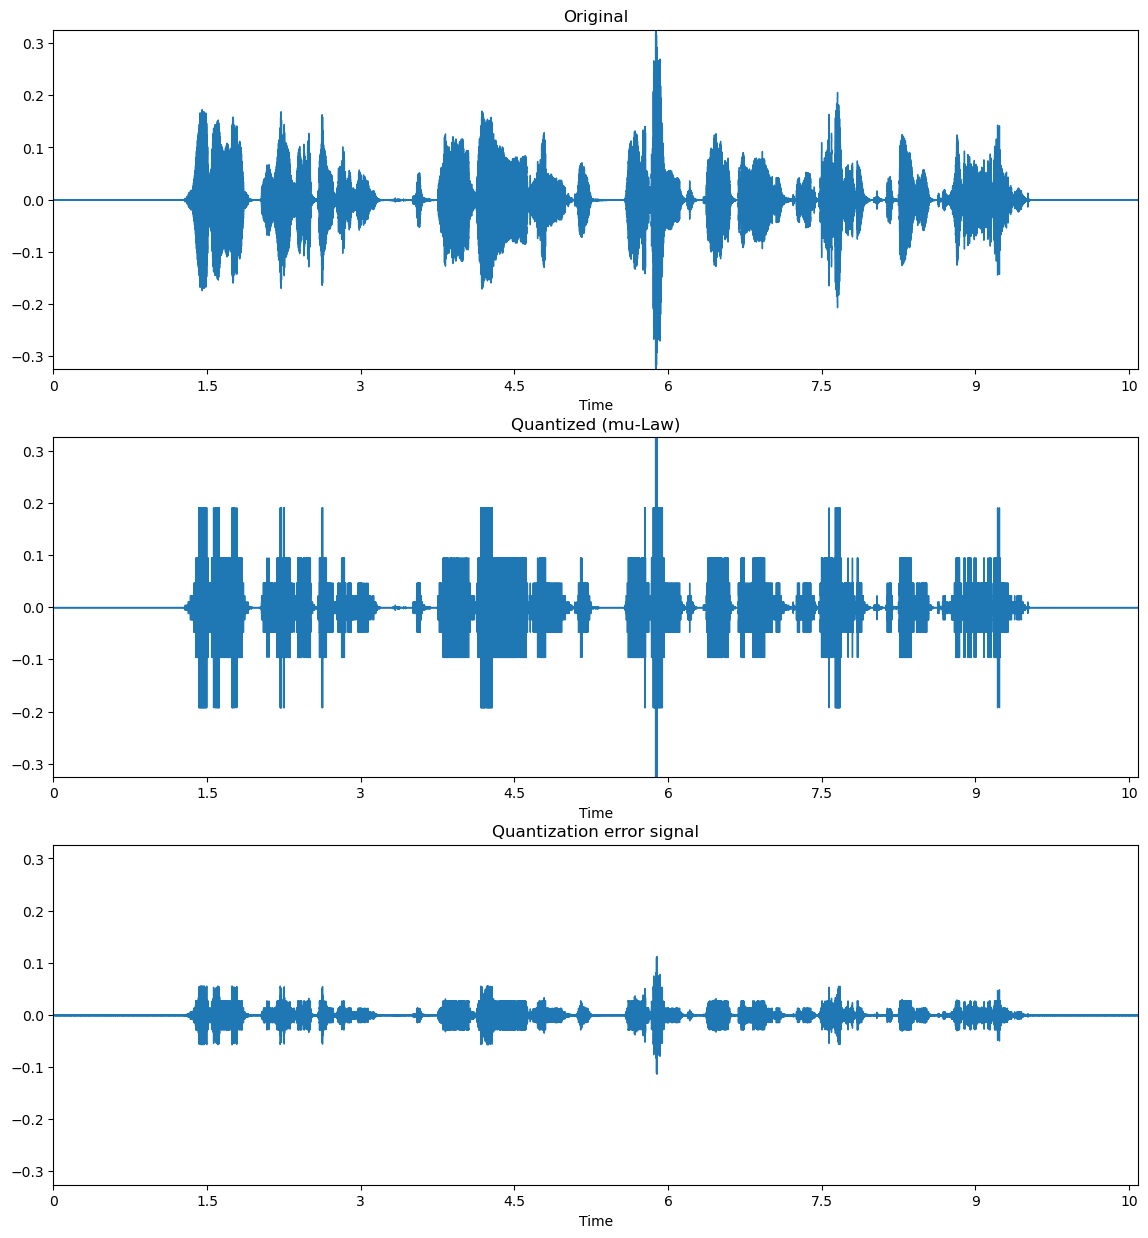

In [11]:
plt.figure(figsize=(14, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveshow(xh_nonuniform, sr=sampling_rate)
plt.title('Quantized (mu-Law)')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveshow(x-xh_nonuniform, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

## Optimal Quantization Using the Lloyd-Max-Algorithm

Compute the Lloyd-Max quantizer using the empirical distribution of the file. Also store the codebook after each iteration for visualization purposes. The Lloyd-Max algorithm applied to a signal $x[k]$ of length $n$ samples can be summarized as follows (see lecture notes).
 1. Generate initial codebook $\hat{\mathcal{X}} = \{\hat{x}_1,\ldots, \hat{x}_K\}$
 2. Calculate decision thresholds $x_i = \frac{\hat{x}_i+\hat{x}_{i+1}}{2}$,  for $i=1,\ldots, K-1$ 
 3. Update quantizer representation levels (with $x_0 = -\infty$ and $x_K=\infty$)
$$
		\hat{x}_i =			\frac{\sum_{k=1}^n x[k]\mathbb{1}_{\{x[k]\in[x_{i-1},x_i)\}}}{\sum_{k=1}^n \mathbb{1}_{\{x[k]\in[x_{i-1},x_i)\}}},  \qquad i=1,\ldots, K
$$	
 4. Go to step 2.) unless converged (i.e., all $\hat{x}_i$ do not change significantly during the iterations)


In [12]:
def Lloyd_Max_Quantizer(initial_cb, x):
    #large number for inifity
    lm_inf = 10*np.max([np.max(x), -np.min(x)])

    codebook = initial_cb.copy()

    while True:
        thresholds = [-lm_inf] + [0.5*(codebook[t]+codebook[t+1]) for t in range(len(codebook)-1)] + [lm_inf]

        old_cb = codebook.copy()
        for k in range(len(codebook)):
            # new codebook center
            # find those samples that are in the quantization interval (indicator function)            
            samples = x[(x >= thresholds[k]) & (x < thresholds[k+1])]
            if len(samples)==0:
                continue
            codebook[k] = sum(samples)/len(samples)
       
        if np.max(np.abs([codebook[i] - old_cb[i] for i in range(len(codebook))])) < 1e-5:
            break
                
    # also return all intermediate codebooks for plotting evolution
    return codebook
    
# carry out quantization based on arbitrary codebook
def quantize(codebook, x):
    #large number for inifity
    lm_inf = 10*np.max([np.max(x), -np.min(x)])

    thresholds = [-lm_inf] + [0.5*(codebook[t]+codebook[t+1]) for t in range(len(codebook)-1)] + [lm_inf]
    
    xh = np.zeros_like(x)
    
    for k in range(len(codebook)):
        # new codebook center
        # find those samples that are in the quantization interval (indicator function)
        idx = (x >= thresholds[k]) & (x < thresholds[k+1])            
        xh[idx] = codebook[k]
        
    return xh

In [13]:
# fix x_max based on the current signal, leave some room
x_max = np.max(x)
x_min = np.min(x)
# arrange codebook exactly between minimum and maximum of file

Delta_x = (x_max-x_min) / (2**w)

# generate codebook of initial midrise uniform quantizer
codebook = list(reversed([-Delta_x/2 - i*Delta_x for i in range(2**(w-1))])) + [Delta_x/2 + i*Delta_x for i in range(2**(w-1))]

# construct codebook using Lloyd-Max Quantizer
newcb = Lloyd_Max_Quantizer(codebook, x)

# quantize
xh_optimal = quantize(newcb, x)

# playback quantized audio
ipd.Audio(xh_optimal, rate=sampling_rate)

(-0.3257324695587158, 0.3257324695587158)

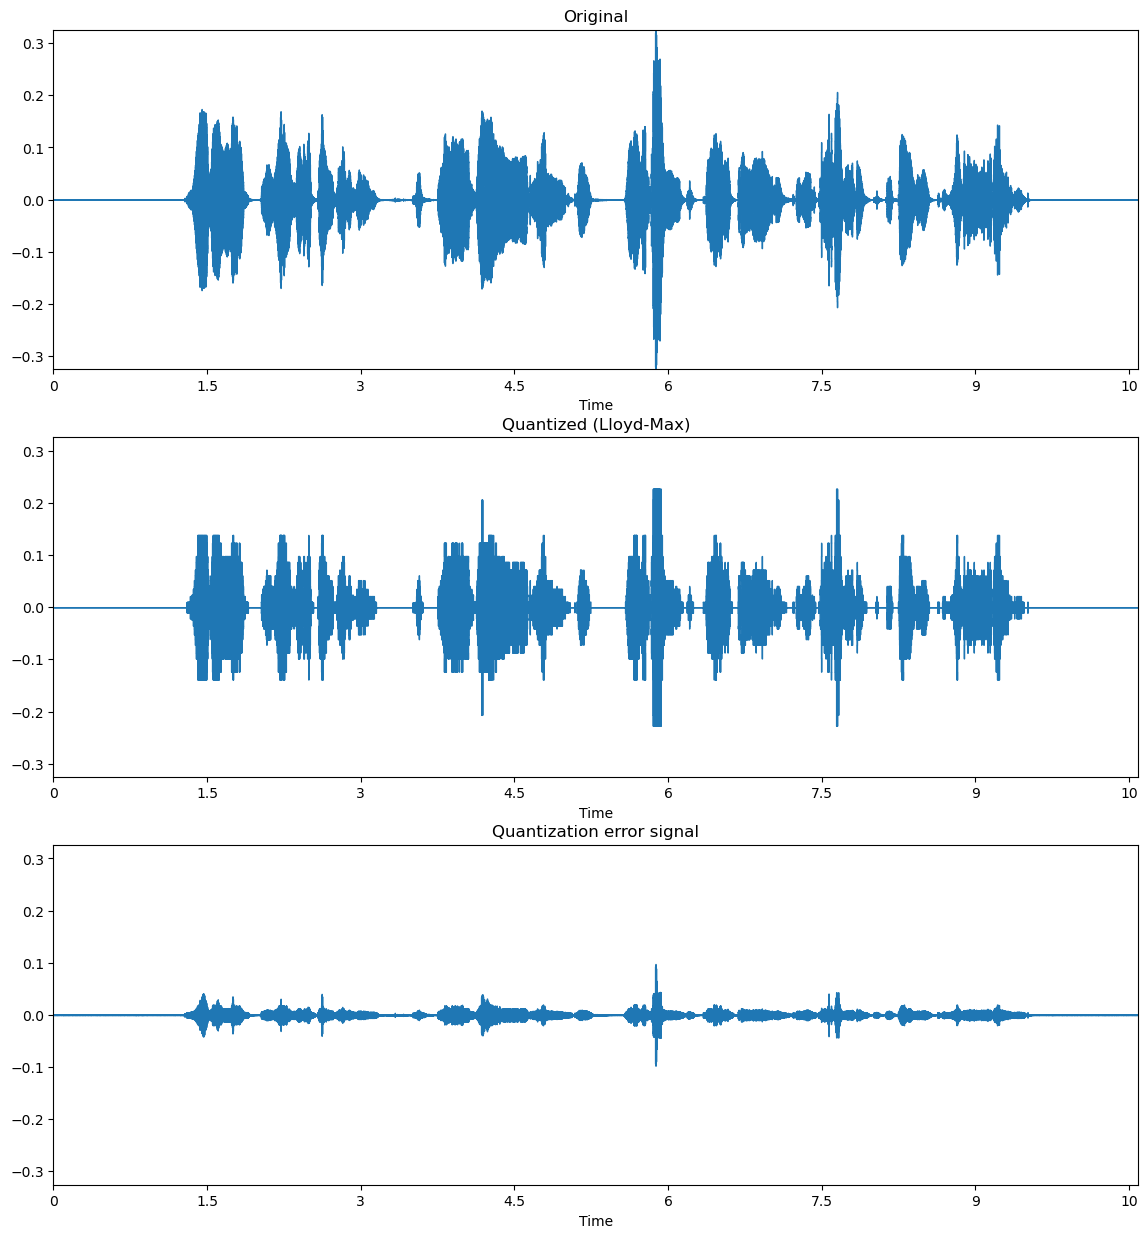

In [14]:
plt.figure(figsize=(14, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveshow(xh_optimal, sr=sampling_rate)
plt.title('Quantized (Lloyd-Max)')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveshow(x-xh_optimal, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

## Adaptive Quantization with Forward Estimation (AQF)

For each block of length $n_{\mathsf{a}}$, estimate the instantenous power
$$
\hat{\sigma}_x^2[k] = \frac{1}{n_{\mathsf{a}}}\sum_{i=0}^{n_{\mathsf{a}}-1}\left(x\left[\left\lceil{k}/{n_{\mathsf{a}}}\right\rceil+i\right]\right)^2
$$
and based on this, select the stepsize
$$
\Delta[k] = c\cdot \hat{\sigma}_x[k]
$$

In [15]:
def AQF(x,c):
    # segment length
    n_a = 256
    segments = int(np.floor(len(x)/n_a))

    x_seg = np.reshape(x[0:segments*n_a],(segments,n_a))

    sigmaq_x = np.mean(np.square(x_seg),axis=1)
    
    xh_seg = np.zeros_like(x_seg)
    
    Delta_x = np.zeros(segments)

    for k in range(segments):
        # quantize each segment
        Delta_x[k] = c * np.sqrt(sigmaq_x[k])
        
        # quantize
        temp = np.sign(x_seg[k,:])*Delta_x[k]*(np.floor(np.abs(x_seg[k,:])/Delta_x[k])+0.5)  
        
        # saturation & clipping
        xh_max = (2**w - 1)*Delta_x[k]/2
        xh_min = -xh_max
        temp[temp >= xh_max] = xh_max
        temp[temp <= xh_min] = xh_min

        xh_seg[k,:] = temp.copy()

    # undo shaping
    xh = np.reshape(xh_seg, segments*n_a)
    
    return xh

**Find the value of $c$ that maximizes the SNR of the whole file (This may not be the best metric).**

To find the optimal $c$, we employ the [Golden-section search](https://en.wikipedia.org/wiki/Golden-section_search). This algorithm finds the maximum over a unimodal function $f(x)$ (i.e., a function with a single maximum) over an interval $[x_1, x_4]$. Let $\varphi = \frac{1+\sqrt{5}}{2} \approx 1.618$ denote the golden ratio.

The algorithm works as follows:
1. Let 
\begin{align*}
x_2 &= x_4 - \frac{x_4-x_1}{\varphi}\\
x_3 &= x_1 + \frac{x_4-x_1}{\varphi}
\end{align*}
2. If $f(x_2) > f(x_3)$, then $x_4 \leftarrow x_3$, otherwise $x_1 \leftarrow x_2$. Then recompute
\begin{align*}
x_2 &= x_4 - \frac{x_4-x_1}{\varphi}\\
x_3 &= x_1 + \frac{x_4-x_1}{\varphi}
\end{align*}
3. If $|x_2-x_3| > \epsilon$, repeat step 2.

The final value $x_{\text{opt}}$ is obtained as $\frac{1}{2}(x_1+x_4)$.

In [16]:
c1 = 0.1
c4 = 50
phi = (1+np.sqrt(5))/2

c2 = c4 - (c4-c1)/phi
c3 = c1 + (c4-c1)/phi

while np.abs(c4-c1) > 1e-5:
    xh = AQF(x,c2)
    SNR2 = 10*np.log10(np.mean(np.square(x))) - 10*np.log10(np.mean(np.square(x[0:len(xh)]-xh)))
    
    xh = AQF(x,c3)
    SNR3 = 10*np.log10(np.mean(np.square(x))) - 10*np.log10(np.mean(np.square(x[0:len(xh)]-xh)))    
    
    if SNR2 > SNR3:
        c4 = c3
    else:
        c1 = c2
    
    c2 = c4 - (c4-c1)/phi
    c3 = c1 + (c4-c1)/phi

# compute final optimizer
c_opt = (c1+c4)/2
print(c_opt)

0.28834280062287154


In [17]:
# fix x_max based on the current signal, leave some room
xh_AQF = AQF(x,c_opt)

# playback quantized audio
ipd.Audio(xh_AQF, rate=sampling_rate)

(-0.3257324695587158, 0.3257324695587158)

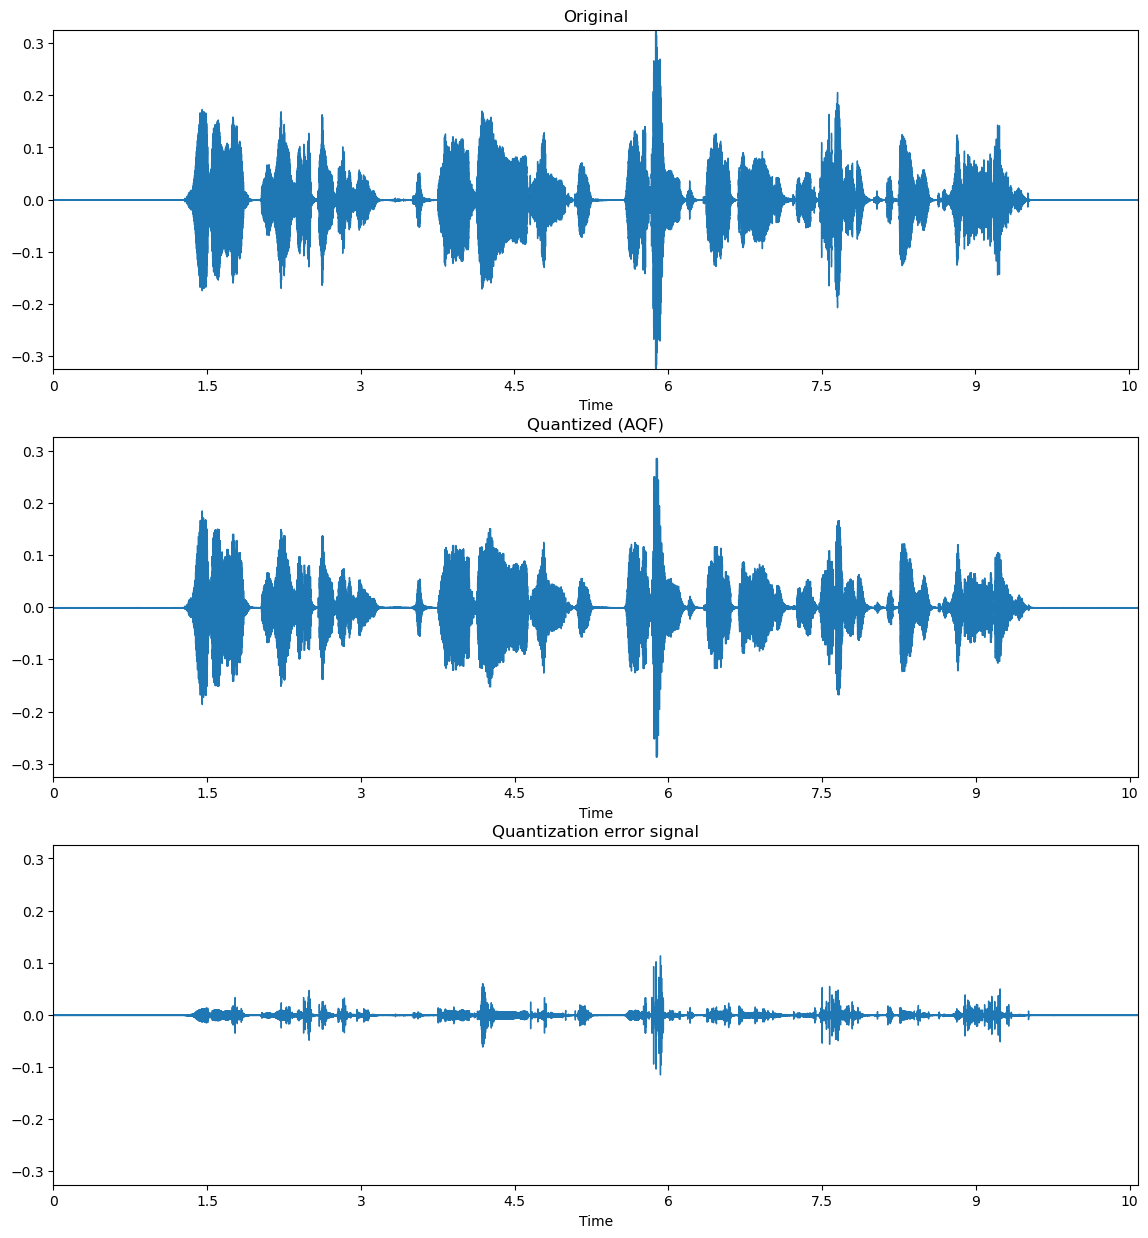

In [18]:
plt.figure(figsize=(14, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveshow(xh_AQF, sr=sampling_rate)
plt.title('Quantized (AQF)')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveshow(x[range(len(xh_AQF))]-xh_AQF, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

## Adaptive Quantization with Backward Estimation (AQB)

The AQB algorithm works on recursive computation of new stepsizes $\Delta[k] = M[k]\cdot \Delta[k-1]$
Quantization of $x[k]$ happens according to
$$
	\hat{x}[k] = \mathrm{sign}(x[k])\cdot Z[k]\cdot \frac{\Delta[k]}{2}
$$
with 
$$
Z[k] = 2 \left\lfloor\frac{x[k]}{\Delta[k]}\right\rfloor+1
$$
The new new stepsize $M[k+1]$ is usually obtained as
$$
	M[k+1] = \sqrt{\alpha + (1-\alpha)Z^2[k]\frac{c^2}{4}}
$$
where $\alpha$ and $c$ are parameters that need to be optimized. Here we use the tables from [Jay73]


[Jay73] N. S. Jayant, "Adaptive Quantization With a One-Word Memory," _Bell System Technical Journal_ , vol. 52, no. 7, pp. 1119--1144, 1973

In [19]:
M_dict = {2: [0.6, 2.2],
          3: [0.85, 1.0, 1.0, 1.5],
          4: [0.8, 0.8, 0.8, 0.8, 1.2, 1.6, 2.0, 2.4],
          5: [0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]}

def AQB(x, w):
    if w in M_dict:
        Ms = M_dict[w]
        
        q_max = 2**(w-1)-1
        
        # initial stepsize 0.1, needs to be known at transmitter and receiver
        # initial multiplier 1
        Delta = 0.1
        M = 1
        
        xh = np.sign(x) # precompute signs
        
        for k in range(len(x)):
            # compute new stepsize
            Delta = Delta * M            
            
            # quantize, this is the operation done at the transmitter, q is being transmitter
            q = int(np.floor(np.abs(x[k])/Delta))            
            # saturate
            if q < 0:
                q = 0
            if q > q_max:
                q = q_max
            
            # reconstruct sample, this is the receiver operation
            xh[k] *= (2*q+1)*Delta/2
            
            # compute new multiplier
            M = Ms[q]
        
        return xh
    else:
        print('AQB not defined for word length w = %d' % w)
        return []

In [20]:
# fix x_max based on the current signal, leave some room
xh_AQB = AQB(x,w)

# playback quantized audio
ipd.Audio(xh_AQB, rate=sampling_rate)

(-0.3257324695587158, 0.3257324695587158)

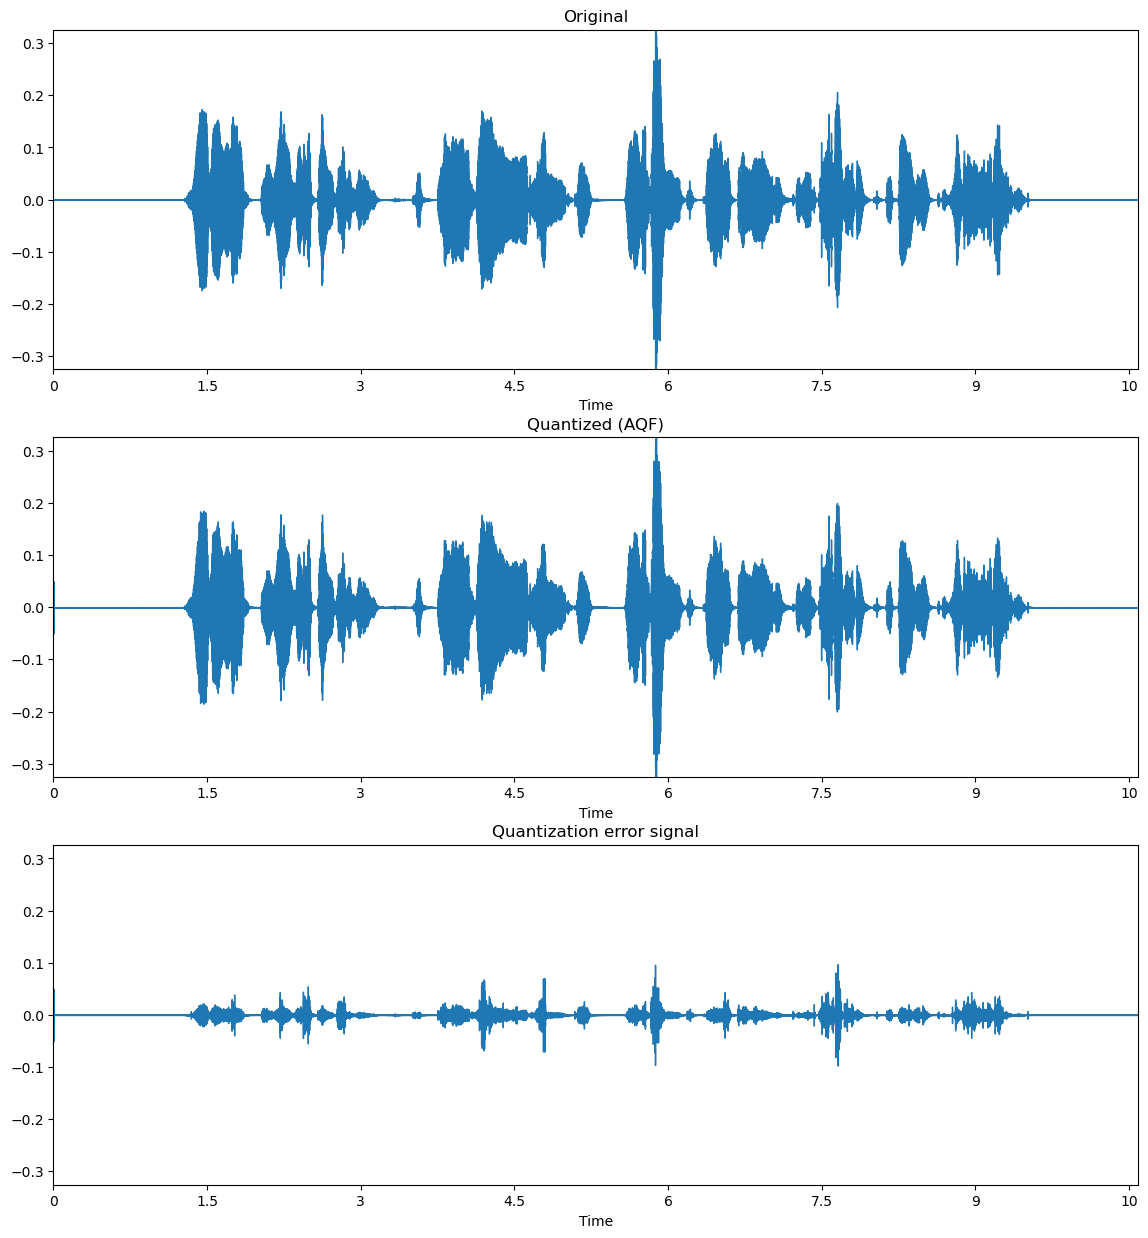

In [21]:
plt.figure(figsize=(14, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveshow(xh_AQB, sr=sampling_rate)
plt.title('Quantized (AQF)')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveshow(x-xh_AQB, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))